In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import glob
import cv2

from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import os
import seaborn as sns
from keras.applications.vgg16 import VGG16

In [2]:
import pickle

pickle_in = open("X_train.pickle","rb")
X_train = pickle.load(pickle_in)

pickle_in = open("y_train.pickle","rb")
y_train = pickle.load(pickle_in)

pickle_in = open("X_test.pickle","rb")
X_test = pickle.load(pickle_in)

pickle_in = open("y_test.pickle","rb")
y_test = pickle.load(pickle_in)

In [3]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((39375, 100, 100, 3), (39375,), (12349, 100, 100, 3), (12349,))

<hr>

In [5]:
# import numpy as np 
# import matplotlib.pyplot as plt
# import glob
# import cv2
# import os
# import seaborn as sns
# import pandas as pd
# from skimage.filters import sobel
# from PIL import Image,ImageEnhance,ImageOps

In [6]:
# #Capture images and labels into arrays.
# #Start by creating empty lists.
# SIZE = 128
# train_images = []
# train_labels = [] 
# for directory_path in glob.glob("./Datasets/Training/*"):
#     label = directory_path.split("\\")[-1]
#     print(label)
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         print(img_path)
#         img = Image.open(img_path)
# #         img = ImageOps.grayscale(img)
# #         img = ImageEnhance.Contrast(img).enhance(2)
# #         img = ImageEnhance.Sharpness(img).enhance(50)
# #         img = ImageEnhance.Brightness(img).enhance(1)
#         img = img.resize((SIZE,SIZE))
#         img = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)
#         train_images.append(img)
#         train_labels.append(label)
        
# train_images = np.array(train_images)
# train_labels = np.array(train_labels)

In [7]:
# train_images.shape , train_labels.shape

In [8]:
# #Do exactly the same for test/validation images
# # test
# test_images = []
# test_labels = [] 
# for directory_path in glob.glob("./Datasets/Test/*"):
#     t_label = directory_path.split("\\")[-1]
#     print(t_label)
#     for img_path in glob.glob(os.path.join(directory_path, "*.jpg")):
#         print(img_path)
#         img = Image.open(img_path)
# #         img = ImageOps.grayscale(img)
# #         img = ImageEnhance.Contrast(img).enhance(2)
# #         img = ImageEnhance.Sharpness(img).enhance(50)
# #         img = ImageEnhance.Brightness(img).enhance(1)
#         img = img.resize((SIZE,SIZE))
#         img = np.array(img.getdata()).reshape(img.size[0], img.size[1], 3)
#         test_images.append(img)
#         test_labels.append(t_label)
        
# test_images = np.array(test_images)
# test_labels = np.array(test_labels)

In [9]:
# test_images.shape,test_labels.shape

In [10]:
# #Encode labels from text (folder names) to integers.
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()

# le.fit(test_labels)
# test_labels_encoded = le.transform(test_labels)

# le.fit(train_labels)
# train_labels_encoded = le.transform(train_labels)

In [ ]:
#Split data into test and train datasets (already split but assigning to meaningful convention)
#If you only have one dataset then split here
# X_train, y_train, X_test, y_test = train_images, train_labels_encoded, test_images, test_labels_encoded

# Normalize pixel values to between 0 and 1
X_train, X_test = X_train / 255.0, X_test / 255.0

In [5]:
#############################
#Load model wothout classifier/fully connected layers
SIZE = 100

VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE, SIZE, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
    layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 25, 25, 128)       0     

In [6]:
#Now, let us use features from convolutional network for RF
feature_extractor=VGG_model.predict(X_train)

In [7]:
features = feature_extractor.reshape(feature_extractor.shape[0], -1)

X_for_training = features #This is our X input to RF

In [8]:
#Send test data through same feature extractor process
X_test_feature = VGG_model.predict(X_test)
X_test_features = X_test_feature.reshape(X_test_feature.shape[0], -1)

### XGBOOST

In [9]:
import xgboost as xgb
model1 = xgb.XGBClassifier()

model1.fit(X_for_training, y_train) #For sklearn no one hot encoding

C:\Users\Lenovo\anaconda3\envs\myDL\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:51:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [10]:
#Now predict using the trained RF model. 
prediction = model1.predict(X_test_features)

In [11]:
#Print overall accuracy
from sklearn import metrics
print ("Training Accuracy = ",  model1.score(X_for_training, y_train))
print ("Testing Accuracy = ", metrics.accuracy_score(y_test, prediction))

Training Accuracy =  1.0
Testing Accuracy =  0.7464572030123897


[[4767 1475]
 [1656 4451]]


<AxesSubplot:>

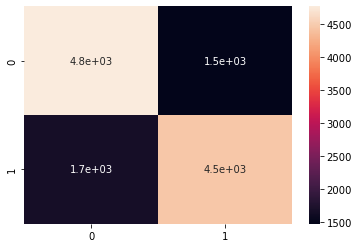

In [12]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction)
print(cm)
sns.heatmap(cm, annot=True)

### RandomForestClassifer

In [17]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

model2 = RandomForestClassifier(n_estimators=150,max_depth=20)
model2.fit(X_for_training, y_train)

RandomForestClassifier(max_depth=20, n_estimators=150)

In [18]:
#Now predict using the trained RF model. 
prediction_2 = model2.predict(X_test_features)

In [19]:
#Print overall accuracy
from sklearn import metrics
print ("Training Accuracy = ",  model2.score(X_for_training, y_train))
print ("Testing Accuracy = ", metrics.accuracy_score(y_test, prediction_2))

Training Accuracy =  0.9997206349206349
Testing Accuracy =  0.8202283585715443


[[5375  867]
 [1353 4754]]


<AxesSubplot:>

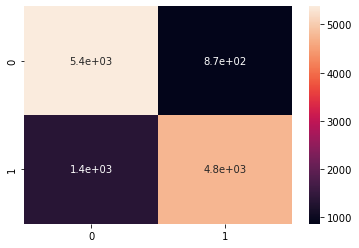

In [20]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_2)
print(cm)
sns.heatmap(cm, annot=True)

### Adaboost

In [9]:
#BASE Learner 
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_for_training, y_train)

C:\Users\Lenovo\anaconda3\envs\myDL\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [10]:
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier

model3 = AdaBoostClassifier(base_estimator=lr,n_estimators=100,learning_rate=1,random_state=42)
model3.fit(X_for_training, y_train)

AdaBoostClassifier(base_estimator=LogisticRegression(), learning_rate=1,
                   n_estimators=100, random_state=42)

In [11]:
#Now predict using the trained RF model. 
prediction_3 = model3.predict(X_test_features)

In [12]:
#Print overall accuracy
from sklearn import metrics
print ("Training Accuracy = ",  model3.score(X_for_training, y_train))
print ("Testing Accuracy = ", metrics.accuracy_score(y_test, prediction_3))

Training Accuracy =  0.9997968253968254
Testing Accuracy =  0.7665398007935865


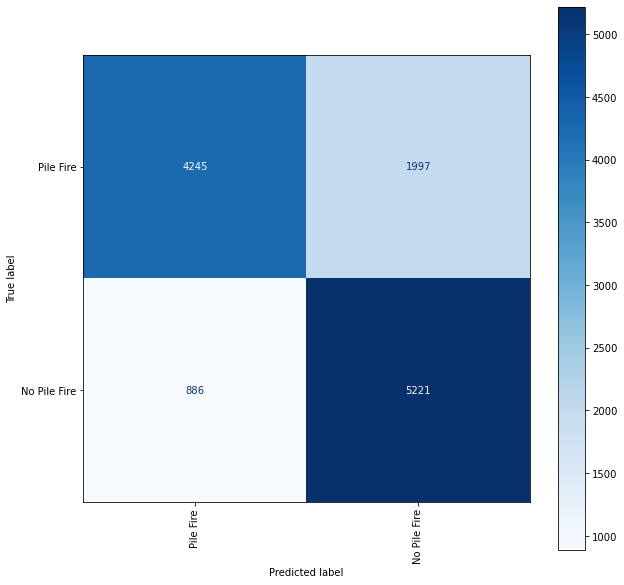

In [13]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

labels = ['Pile Fire','No Pile Fire']

cm = confusion_matrix(y_test, prediction_3)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(10,10))

disp.plot(cmap=plt.cm.Blues,ax=ax, xticks_rotation='vertical')


plt.show()

### GBoost

In [ ]:
# Decision Tree Score -
from sklearn import tree
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier(n_estimators=100,learning_rate=1)
model4.fit(X_for_training, y_train)

In [ ]:
prediction_4 = model4.predict(X_test_features)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Training Accuracy = ",  model4.score(X_for_training, y_train))
print ("Testing Accuracy = ", metrics.accuracy_score(y_test, prediction_4))

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_4)
print(cm)
sns.heatmap(cm, annot=True)

### Extra Tree Classifier

In [ ]:
from sklearn import tree
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=150,random_state=0)
etr.fit(X_for_training, y_train)

In [ ]:
prediction_etc = etr.predict(X_test_features)

In [ ]:
#Print overall accuracy
from sklearn import metrics
print ("Training Accuracy = ",  etr.score(X_for_training, y_train))
print ("Testing Accuracy = ", metrics.accuracy_score(y_test, prediction_etc))

In [ ]:
#Confusion Matrix - verify accuracy of each class
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, prediction_etc)
print(cm)
sns.heatmap(cm, annot=True)

### VotingClassifer

In [57]:
import numpy as np

X = np.r_[X_for_training, X_test_features]
y = np.r_[y_train, y_test]

print(X)

[[0.         0.         0.7317321  ... 0.         0.8163526  0.        ]
 [0.         0.         0.2209526  ... 0.         1.036103   0.        ]
 [0.         0.         0.         ... 0.         0.9050437  0.        ]
 ...
 [0.5215284  0.         0.         ... 0.         0.9135845  0.        ]
 [0.         0.         0.         ... 0.         0.6543861  0.        ]
 [0.23692727 0.         0.         ... 0.         0.75730354 0.        ]]


In [58]:
print(y)

[0 0 1 ... 0 1 1]


In [59]:
import numpy as np
import warnings
from sklearn import datasets
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB 
warnings.filterwarnings("ignore")

In [60]:
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()

print('5-fold cross validation:\n')

labels = ['Logistic Regression', 'Random Forest', 'Naive Bayes']

for clf, label in zip([clf1, clf2, clf3], labels):

    scores = model_selection.cross_val_score(clf, X, y, 
                                              cv=5, 
                                              scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

5-fold cross validation:

Accuracy: 0.91 (+/- 0.18) [Logistic Regression]
Accuracy: 0.90 (+/- 0.19) [Random Forest]
Accuracy: 0.90 (+/- 0.14) [Naive Bayes]


In [61]:
voting_clf_hard = VotingClassifier(estimators = [(labels[0], clf1),
                                                 (labels[1], clf2),
                                                 (labels[2], clf3)],
                                   voting = 'hard')

In [62]:
voting_clf_soft = VotingClassifier(estimators = [(labels[0], clf1),
                                                 (labels[1], clf2),
                                                 (labels[2], clf3)],
                                   voting = 'soft')

In [63]:
labels_new = ['Logistic Regression', 'Random Forest', 'Naive Bayes',
              'Voting_Classifier_Hard', 'Voting_Classifier_Soft']

for (clf, label) in zip([clf1, clf2, clf3, voting_clf_hard,
                        voting_clf_soft], labels_new):
    scores = model_selection.cross_val_score(clf, X, y, cv=5,
            scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))

Accuracy: 0.91 (+/- 0.18) [Logistic Regression]
Accuracy: 0.90 (+/- 0.19) [Random Forest]
Accuracy: 0.90 (+/- 0.14) [Naive Bayes]
Accuracy: 0.91 (+/- 0.18) [Voting_Classifier_Hard]
Accuracy: 0.91 (+/- 0.17) [Voting_Classifier_Soft]


NameError: name 'model' is not defined

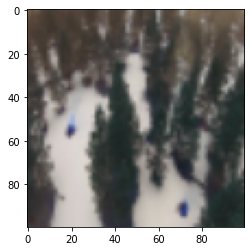

In [64]:
#Check results on a few select images
n=np.random.randint(0, X_test.shape[0])
img = X_test[n]
plt.imshow(img)
input_img = np.expand_dims(img, axis=0) #Expand dims so the input is (num images, x, y, c)
input_img_feature=VGG_model.predict(input_img)
input_img_features=input_img_feature.reshape(input_img_feature.shape[0], -1)
prediction = model.predict(input_img_features)[0] 
# prediction = le.inverse_transform([prediction])  #Reverse the label encoder to original name
print(" 0 - Fire  |  1 - No_Fire ")
print("The prediction for this image is: ", prediction)
print("The actual label for this image is: ", y_test[n])